<a href="https://colab.research.google.com/github/Daysiday/Daysiday/blob/main/Copia_de_Clasificacion_de_Imagenes_con_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar librerias

In [1]:
# Instalar TensorFlow Datasets (si es necesario)
!pip install tensorflow-datasets

In [2]:
# Importar librerías
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Verificar GPU
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Cargar el dataset

In [4]:
# Cargar el dataset desde TensorFlow Datasets
dataset, info = tfds.load('cats_vs_dogs', split='train', with_info=True)

# Dividir en entrenamiento, validación y prueba
train_data = dataset.take(15000)
val_data = dataset.skip(15000).take(2500)
test_data = dataset.skip(17500).take(2500)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.VYHUTP_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


# Preprocesamiento del Dataset

In [5]:
# Función para redimensionar y normalizar imágenes
def preprocess(features):
    image = tf.image.resize(features['image'], (150, 150))
    image = image / 255.0  # Normalizar a [0,1]
    return image, features['label']

# Aplicar preprocesamiento y preparar batches
batch_size = 64
train_data = train_data.map(preprocess).shuffle(1000).batch(batch_size).prefetch(1)
val_data = val_data.map(preprocess).batch(batch_size).prefetch(1)
test_data = test_data.map(preprocess).batch(batch_size).prefetch(1)

# Visualizacion del dataset

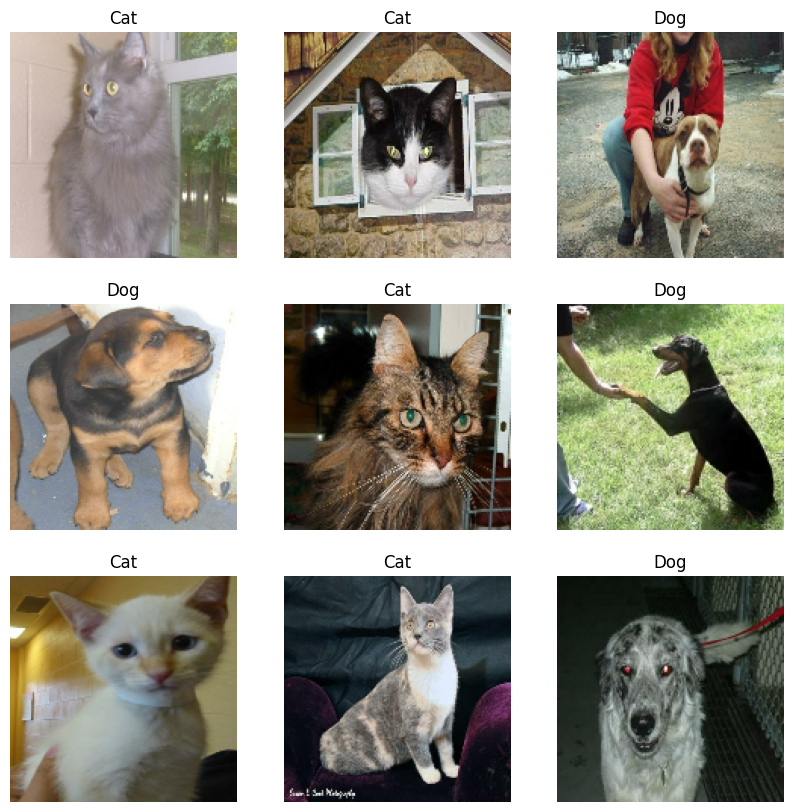

In [6]:
# Mostrar imágenes con etiquetas
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Cat' if labels[i] == 0 else 'Dog')
        plt.axis('off')
plt.show()

# Construir el modelo CNN

In [7]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Salida binaria (0: gato, 1: perro)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compilar el modelo

In [8]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenar el modelo

In [9]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10  # Aumenta las épocas para mejor precisión
)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 52s 181ms/step - accuracy: 0.5845 - loss: 0.7677 - val_accuracy: 0.6972 - val_loss: 0.5628
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - accuracy: 0.7126 - loss: 0.5556 - val_accuracy: 0.7728 - val_loss: 0.4841
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - accuracy: 0.7630 - loss: 0.4872 - val_accuracy: 0.7856 - val_loss: 0.4566
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 34s 139ms/step - accuracy: 0.8080 - loss: 0.4068 - val_accuracy: 0.8048 - val_loss: 0.4488
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 34s 141ms/step - accuracy: 0.8524 - loss: 0.3331 - val_accuracy: 0.8032 - val_loss: 0.4887
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 39s 163ms/step - accuracy: 0.8949 - loss: 0.2520 - val_accuracy: 0.8112 - val_loss: 0.5303
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - accuracy: 0.9419 - loss: 0.1495 - val_accuracy: 0.8124 - val_loss: 0.6041
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - accuracy: 0.9706 - loss: 0

# Visualizar metricas de entrenamiento

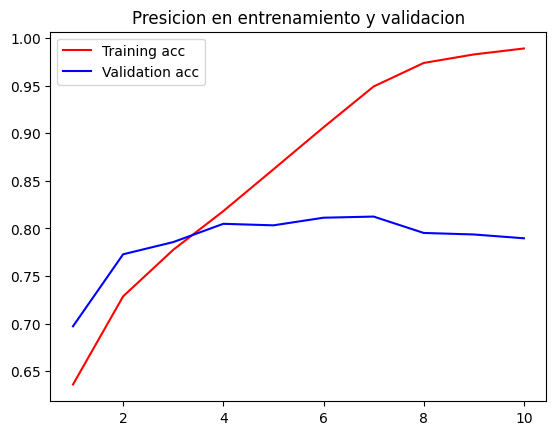

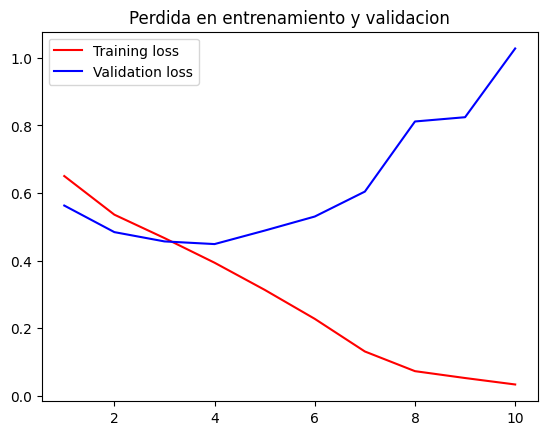

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Presicion en entrenamiento y validacion')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Perdida en entrenamiento y validacion')
plt.legend()
plt.show()

# Evaluar el modelo entrenado

In [11]:
# Evaluar con el test set
test_loss, test_acc = model.evaluate(test_data)
print(f'Precisión en test: {test_acc*100:.2f}%')

40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.7952 - loss: 1.0887
Precisión en test: 79.84%


# Inferencia del modelo

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


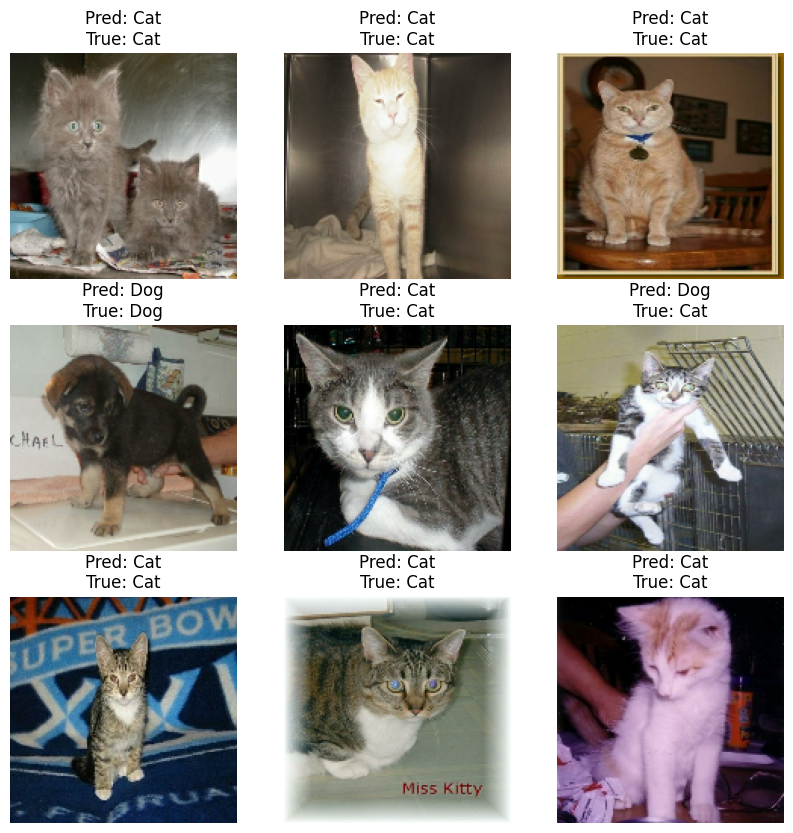

In [12]:
# Predecir en imágenes de prueba
predictions = model.predict(test_data.take(1))
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        predicted_label = 'Cat' if predictions[i] < 0.5 else 'Dog'
        true_label = 'Cat' if labels[i] == 0 else 'Dog'
        plt.title(f'Pred: {predicted_label}\nTrue: {true_label}')
        plt.axis('off')
plt.show()



---



# Aplicar "Data Augmentation" para reducir el overfitting

In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models

# Cargar el dataset desde TensorFlow Datasets
dataset, info = tfds.load('cats_vs_dogs', split='train', with_info=True)

# Dividir en entrenamiento, validación y prueba
train_data = dataset.take(15000)
val_data = dataset.skip(15000).take(2500)
test_data = dataset.skip(17500).take(2500)

# Función para redimensionar y normalizar imágenes
def preprocess(features):
    image = tf.image.resize(features['image'], (150, 150))
    image = image / 255.0  # Normalizar a [0,1]
    return image, features['label']

# Pipeline de Data Augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Función para aplicar data augmentation al batch de entrenamiento
def augment(image, label):
    image = data_augmentation(image)
    return image, label

batch_size = 32

# Aplicar preprocesamiento y preparar batches
train_data = (train_data
              .map(preprocess)
              .shuffle(1000)
              .batch(batch_size)
              .map(augment)  # Aquí se aplica la data augmentación
              .prefetch(1))
val_data = val_data.map(preprocess).batch(batch_size).prefetch(1)
test_data = test_data.map(preprocess).batch(batch_size).prefetch(1)

## Construir un nuevo modelo con capas de Normalizacion

In [14]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout para reducir el overfitting
    layers.Dense(1, activation='sigmoid')  # Salida binaria (0: gato, 1: perro)
])

## Compilar el modelo optimizado

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenar nuevamente

In [16]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10  # Aumenta las épocas para mejor precisión
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 225ms/step - accuracy: 0.5400 - loss: 0.7407 - val_accuracy: 0.6408 - val_loss: 0.6423
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 231ms/step - accuracy: 0.6386 - loss: 0.6393 - val_accuracy: 0.6660 - val_loss: 0.6177
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 106s 223ms/step - accuracy: 0.6752 - loss: 0.6039 - val_accuracy: 0.6844 - val_loss: 0.5869
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.7117 - loss: 0.5653 - val_accuracy: 0.7384 - val_loss: 0.5290
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 232ms/step - accuracy: 0.7396 - loss: 0.5246 - val_accuracy: 0.7320 - val_loss: 0.5585
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 105s 222ms/step - accuracy: 0.7515 - loss: 0.5115 - val_accuracy: 0.7756 - val_loss: 0.4741
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 146s 230ms/step - accuracy: 0.7698 - loss: 0.4825 - val_accuracy: 0.7764 - val_loss: 0.4883
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 220ms/step - accuracy: 0.7781 -

## Visualizar metricas de entrenamiento

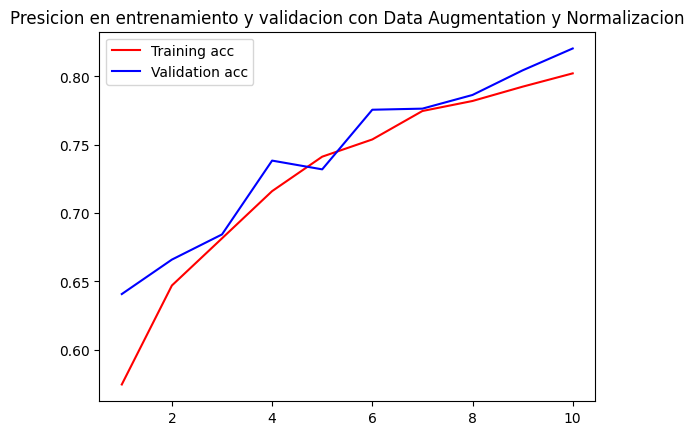

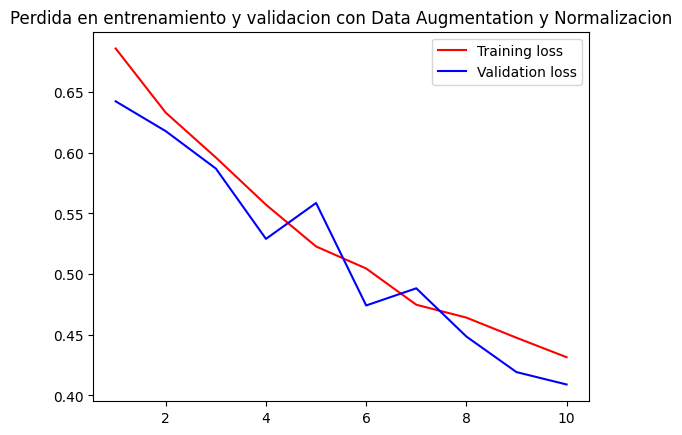

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Presicion en entrenamiento y validacion con Data Augmentation y Normalizacion')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Perdida en entrenamiento y validacion con Data Augmentation y Normalizacion')
plt.legend()
plt.show()

# Validar el modelo Con metricas Presicion, recall y F1 score

In [18]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Acumular etiquetas verdaderas y predichas
y_true = []
y_pred = []

# Iterar sobre el dataset de test
for images, labels in test_data:
    # Obtener las predicciones del modelo (probabilidades)
    preds = model.predict(images)
    # Convertir probabilidades a etiquetas binarias (0 o 1) usando un umbral de 0.5
    preds_binary = (preds > 0.5).astype("int32")

    y_pred.extend(preds_binary.flatten())
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calcular las métricas
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precisión: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

# Guardar el modelo

In [19]:
model.save('mi_modelo_clasificador.h5')